In [1]:
# Import Libraries

from statsbombpy import sb

## Math Operations
import numpy as np
import math

## Data Preprocessing
import pandas as pd

## Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import to_rgba
from matplotlib import rcParams
import seaborn as sns
import networkx as nx
from PIL import Image
from highlight_text import ax_text, fig_text
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen
import mplsoccer
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

## Requests and downloads
import tqdm
import requests
from urllib.request import urlopen

## Filter warning
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load Statsbomb UEFA EURO 2020 matches
parser = Sbopen()
df_match = parser.match(competition_id=55, season_id=43)
match_ids = df_match.match_id.unique()

## xT (Set Pieces included )

In [3]:
# create a dataframe of all the events
all_events_df = []
cols = ['match_id', 'id', 'type_name', 'sub_type_name', 'player_name',
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']
for match_id in match_ids:
    # get carries/ passes/ shots
    event = parser.event(match_id)[0]  # get the first dataframe (events) which has index = 0
    event = event.loc[event.team_id == 914] # Italy
    event = event.loc[event.type_name.isin(['Carry', 'Shot', 'Pass']), cols].copy()

    # boolean columns for working out probabilities
    event['goal'] = event['outcome_name'] == 'Goal'
    event['shoot'] = event['type_name'] == 'Shot'
    event['move'] = event['type_name'] != 'Shot'
    
    all_events_df.append(event)
    
event = pd.concat(all_events_df)

In [4]:
# pitch divided in 16 cells x 12 cells

pitch = Pitch(line_zorder=2)
bins = (16, 12)  # 16 cells x 12 cells

shot_probability = pitch.bin_statistic(event['x'], event['y'], values=event['shoot'],
                                       statistic='mean', bins=bins)

move_probability = pitch.bin_statistic(event['x'], event['y'], values=event['move'],
                                       statistic='mean', bins=bins)

goal_probability = pitch.bin_statistic(event.loc[event['shoot'], 'x'],
                                       event.loc[event['shoot'], 'y'],
                                       event.loc[event['shoot'], 'goal'],
                                       statistic='mean', bins=bins)

In [5]:
# get a dataframe of move events and filter it so the dataframe only contains actions inside the pitch.
move = event[event['move']].copy()

bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)

move = move[bin_start_locations['inside']].copy()

# get the successful moves, which filters out the events that ended outside the pitch or where not successful (null)
bin_end_locations = pitch.bin_statistic(move['end_x'], move['end_y'], bins=bins)

move_success = move[(bin_end_locations['inside']) & (move['outcome_name'].isnull())].copy()

# get a dataframe of the successful moves and the grid cells they started and ended in
bin_success_start = pitch.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = pitch.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)

df_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                       'y': bin_success_start['binnumber'][1],
                       'end_x': bin_success_end['binnumber'][0],
                       'end_y': bin_success_end['binnumber'][1]})

# calculate the bin counts for the successful moves, i.e. the number of moves between grid cells
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

# create the move_transition_matrix of shape (num_y_bins, num_x_bins, num_y_bins, num_x_bins) 
# this is the number of successful moves between grid cells.
num_y, num_x = shot_probability['statistic'].shape

move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

# and divide by the starting locations for all moves (including unsuccessful)
# to get the probability of moving the ball successfully between grid cells
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2, 3))

move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations != 0,)

In [6]:
move_transition_matrix = np.nan_to_num(move_transition_matrix)

shot_probability_matrix = np.nan_to_num(shot_probability['statistic'])

move_probability_matrix = np.nan_to_num(move_probability['statistic'])

goal_probability_matrix = np.nan_to_num(goal_probability['statistic'])

In [7]:
# calculate xT

xt = np.multiply(shot_probability_matrix, goal_probability_matrix)

diff = 1
iteration = 0

while np.any(diff > 0.00001):  # iterate until the differences between the old and new xT is small
    
    xt_copy = xt.copy()  # keep a copy for comparing the differences
    
    # calculate the new expected threat
    xt = (np.multiply(shot_probability_matrix, goal_probability_matrix) +
          np.multiply(move_probability_matrix,
          np.multiply(move_transition_matrix, 
          np.expand_dims(xt, axis=(0, 1))).sum(axis=(2, 3)))
          )
    
    diff = (xt - xt_copy)
    
    iteration += 1
    
print('Number of iterations:', iteration)

Number of iterations: 61


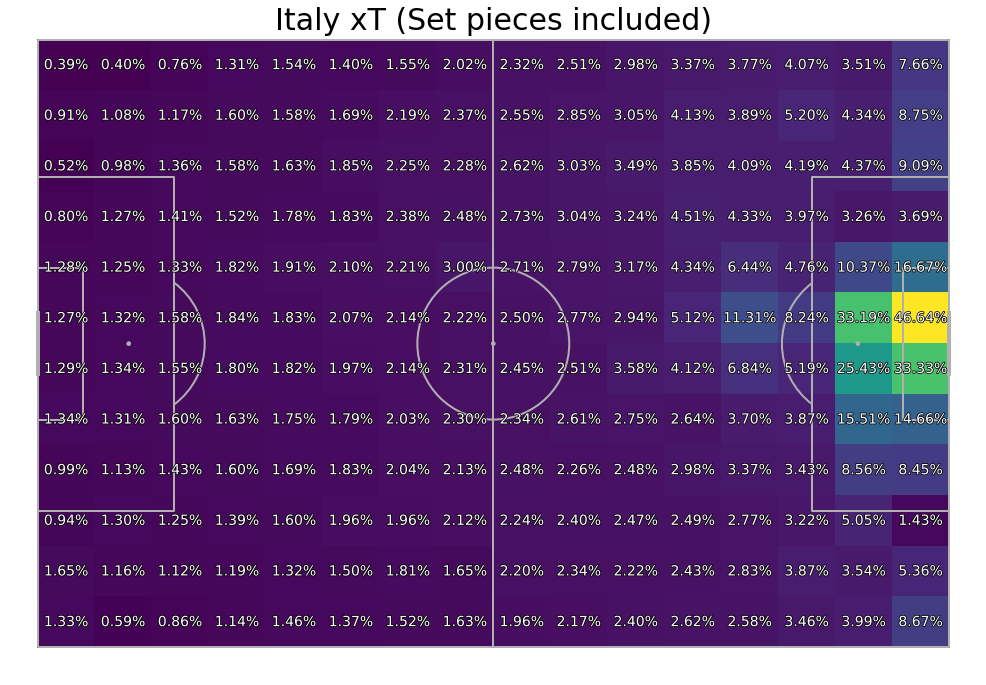

In [8]:
# Plot the xT ex. set pieces for Italy team 

path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# new bin statistic for plotting xt only
for_plotting = pitch.bin_statistic(event['x'], event['y'], bins=bins)
for_plotting['statistic'] = xt

fig, ax = pitch.draw(figsize=(14, 9.625))
_ = pitch.heatmap(for_plotting, ax=ax)
_ = pitch.label_heatmap(for_plotting, ax=ax, str_format='{:.2%}',
                        color='white', fontsize=14, va='center', ha='center',
                        path_effects=path_eff)

ax_title = ax.set_title('Italy xT (Set pieces included)', fontsize=30, pad=-20)

#plt.show()
plt.savefig("ITA_xT_all.jpg", bbox_inches = 'tight')

In [9]:
# first get grid start and end cells
grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins=bins)
grid_end = pitch.bin_statistic(move_success.end_x, move_success.end_y, bins=bins)

# then get the xT values from the start and end grid cell
start_xt = xt[grid_start['binnumber'][1], grid_start['binnumber'][0]]
end_xt = xt[grid_end['binnumber'][1], grid_end['binnumber'][0]]

# then calculate the added xT
added_xt = end_xt - start_xt
move_success['xt'] = added_xt

# show players with top 5 total expected threat
move_success.groupby('player_name')['xt'].sum().sort_values(ascending=False).head(5)

player_name
Lorenzo Insigne        2.761352
Leonardo Spinazzola    1.482446
Marco Verratti         1.441977
Leonardo Bonucci       1.350400
Domenico Berardi       1.337978
Name: xt, dtype: float64

## xT (Set Pieces excluded)

In [10]:
df_without_setpieces = []
set_pieces = ['Throw-in', 'Free Kick', 'Goal Kick', 'Corner', 'Kick Off', 'Penalty']
cols = ['match_id', 'id', 'type_name', 'sub_type_name', 'player_name',
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']

for match_id in match_ids:
    # get carries/ passes/ shots
    event = parser.event(match_id)[0]  # get the first dataframe (events) which has index = 0
    event = event.loc[event.team_id == 914] # Italy
    event = event.loc[((event.type_name.isin(['Carry', 'Shot', 'Pass'])) &
                       (~event['sub_type_name'].isin(set_pieces))),  # remove set-piece events
                      cols].copy()

    # boolean columns for working out probabilities
    event['goal'] = event['outcome_name'] == 'Goal'
    event['shoot'] = event['type_name'] == 'Shot'
    event['move'] = event['type_name'] != 'Shot'
    
    df_without_setpieces.append(event)
    
event_without_setpieces = pd.concat(df_without_setpieces)

In [11]:
shot_probability_without_setpieces = pitch.bin_statistic(event_without_setpieces['x'], 
                                       event_without_setpieces['y'], 
                                       values=event_without_setpieces['shoot'],
                                       statistic='mean', bins=bins)

move_probability_without_setpieces = pitch.bin_statistic(event_without_setpieces['x'], 
                                       event_without_setpieces['y'], 
                                       values=event_without_setpieces['move'],
                                       statistic='mean', bins=bins)

goal_probability_without_setpieces = pitch.bin_statistic(event_without_setpieces.loc[event_without_setpieces['shoot'], 'x'],
                                       event_without_setpieces.loc[event_without_setpieces['shoot'], 'y'],
                                       event_without_setpieces.loc[event_without_setpieces['shoot'], 'shot_statsbomb_xg'],
                                       statistic='mean',
                                       bins=bins)

In [12]:
# get a dataframe of move events and filter it so the dataframe only contains actions inside the pitch.
move = event_without_setpieces[event_without_setpieces['move']].copy()

bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)

move = move[bin_start_locations['inside']].copy()

# get the successful moves, which filters out the events that ended outside the pitch or where not successful (null)
bin_end_locations = pitch.bin_statistic(move['end_x'], move['end_y'], bins=bins)

move_success = move[(bin_end_locations['inside']) & (move['outcome_name'].isnull())].copy()

# get a dataframe of the successful moves and the grid cells they started and ended in
bin_success_start = pitch.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = pitch.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)

df_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                       'y': bin_success_start['binnumber'][1],
                       'end_x': bin_success_end['binnumber'][0],
                       'end_y': bin_success_end['binnumber'][1]})

# calculate the bin counts for the successful moves, i.e. the number of moves between grid cells
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

# create the move_transition_matrix of shape (num_y_bins, num_x_bins, num_y_bins, num_x_bins)
# this is the number of successful moves between grid cells.
num_y, num_x = shot_probability_without_setpieces['statistic'].shape

move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

# and divide by the starting locations for all moves (including unsuccessful)
# to get the probability of moving the ball successfully between grid cells
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2, 3))

move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations != 0,)

In [13]:
move_transition_matrix_without_setpieces = np.nan_to_num(move_transition_matrix)
shot_probability_matrix_without_setpieces = np.nan_to_num(shot_probability_without_setpieces['statistic'])
move_probability_matrix_without_setpieces = np.nan_to_num(move_probability_without_setpieces['statistic'])
goal_probability_matrix_without_setpieces = np.nan_to_num(goal_probability_without_setpieces['statistic'])

In [14]:
# calculate xT

xt_without_setpieces = np.multiply(shot_probability_matrix_without_setpieces, goal_probability_matrix_without_setpieces)

diff = 1
iteration = 0

while np.any(diff > 0.00001):  # iterate until the differences between the old and new xT is small
    
    xt_without_setpieces_copy = xt_without_setpieces.copy()  # keep a copy for comparing the differences
    
    # calculate the new expected threat
    xt_without_setpieces = (np.multiply(shot_probability_matrix_without_setpieces, 
                                        goal_probability_matrix_without_setpieces) +
                            np.multiply(move_probability_matrix_without_setpieces,
                            np.multiply(move_transition_matrix_without_setpieces, 
                            np.expand_dims(xt, axis=(0, 1))).sum(axis=(2, 3)))
                            )
    
    diff = (xt_without_setpieces - xt_without_setpieces_copy)
    
    iteration += 1
    
print('Number of iterations:', iteration)

Number of iterations: 2


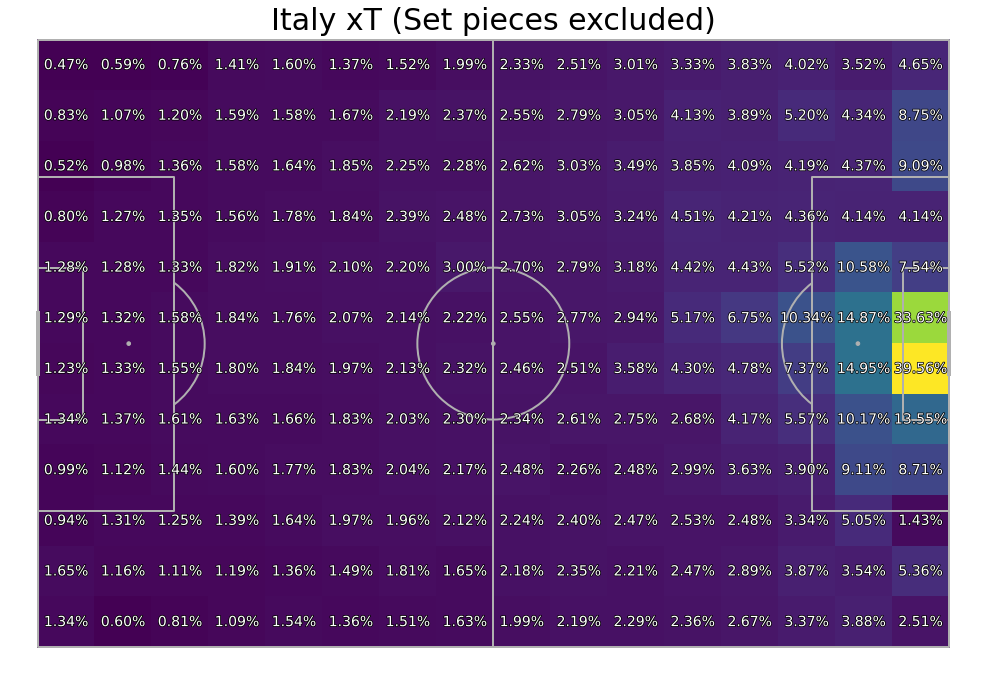

In [15]:
# Plot the xT ex. set pieces for Italy team 

path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# new bin statistic for plotting xt only
for_plotting = pitch.bin_statistic(event_without_setpieces['x'], event_without_setpieces['y'], bins=bins)
for_plotting['statistic'] = xt_without_setpieces
fig, ax = pitch.draw(figsize=(14, 9.625))
_ = pitch.heatmap(for_plotting, ax=ax)
_ = pitch.label_heatmap(for_plotting, ax=ax, str_format='{:.2%}',
                        color='white', fontsize=14, va='center', ha='center',
                        path_effects=path_eff)

ax_title = ax.set_title('Italy xT (Set pieces excluded)', fontsize=30, pad=-20)

#plt.show()
plt.savefig("ITA_xT_no_sp.jpg", bbox_inches = 'tight')

In [16]:
# first get grid start and end cells
grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins=bins)
grid_end = pitch.bin_statistic(move_success.end_x, move_success.end_y, bins=bins)

# then get the xT values from the start and end grid cell
start_xt_without_setpieces = xt_without_setpieces[grid_start['binnumber'][1], grid_start['binnumber'][0]]
end_xt_without_setpieces = xt_without_setpieces[grid_end['binnumber'][1], grid_end['binnumber'][0]]

# then calculate the added xT
added_xt_without_setpieces = end_xt_without_setpieces - start_xt_without_setpieces
move_success['xt_without_setpieces'] = added_xt_without_setpieces

# show players with top 5 total expected threat
move_success_gr = move_success.groupby('player_name')['xt_without_setpieces'].sum().sort_values(ascending = False).head(5)

In [17]:
df_move_success_gr = move_success_gr.to_frame()
df_move_success_gr

,xt_without_setpieces
player_name,
Leonardo Spinazzola,1.311801
Leonardo Bonucci,1.122993
Domenico Berardi,1.089451
Federico Chiesa,1.062512
Marco Verratti,0.973458


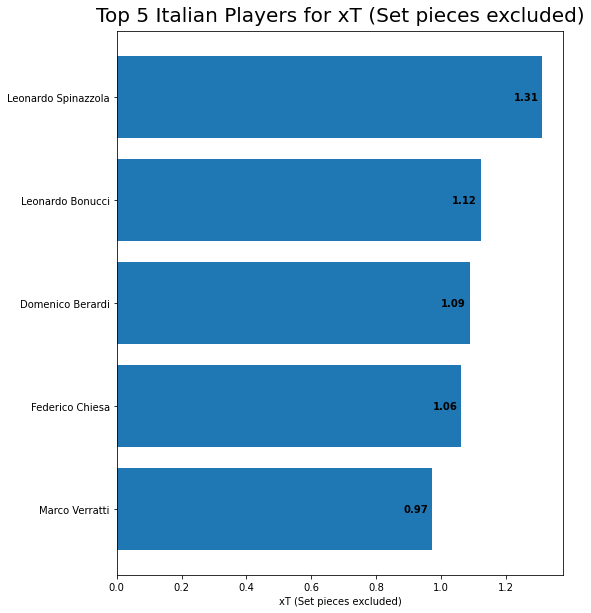

In [19]:
# plot players with top 5 total expected threat

plt.figure(figsize = (8,10))

ax = plt.gca().invert_yaxis()

plt.barh(y = df_move_success_gr.index, width = df_move_success_gr['xt_without_setpieces'])

for i,r in df_move_success_gr.iterrows():
  value = r['xt_without_setpieces']
  plt.annotate(s = f'{value:.2f}', xy = (value-0.05, i), horizontalalignment = 'center', 
               verticalalignment = 'center', weight = 'bold')
    
plt.yticks(df_move_success_gr.index, labels = df_move_success_gr.index)
plt.xlabel('xT (Set pieces excluded)')

plt_title = plt.title('Top 5 Italian Players for xT (Set pieces excluded)', fontsize=20, pad=10)

# plt.show()
plt.savefig("ITA_xT_TOP5.jpg", bbox_inches = 'tight')